In [846]:
import pandas as pd
import numpy as np
import random
import math
import pickle

In [847]:
df = pd.read_csv("../assets/mock_dataset_cleaned.csv")
df.head(10) # All time in str, need convert for binning

,customer,interarrival_time,service_time,arrival_time,service_start,service_end,wait_time,process_duration,queue_length,rating,price_paid,category,postal_code,lat,long
0,1,4.78,10.30,10.07,10.07,10.25,0.00,10.30,1,3,4.8,H,508913,1.37093,103.97119
1,2,3.83,7.22,10.13,10.25,10.37,6.47,13.68,2,5,4.8,H,540330,1.39681,103.88936
2,3,9.78,6.77,10.30,10.37,10.48,3.92,10.67,2,3,22.8,PWBH,670260,1.38840,103.78793
3,4,0.38,10.42,11.30,11.30,11.48,0.00,10.42,1,4,22.8,PWBH,460211,1.32560,103.93241
4,5,0.58,13.18,11.32,11.48,11.70,9.83,23.03,2,1,4.8,H,470631,1.33331,103.91448
5,6,6.05,9.82,11.42,11.70,11.87,16.97,26.78,3,1,4.8,H,330027,1.31884,103.86282
6,7,17.00,13.45,11.70,11.87,12.08,9.78,23.22,2,3,4.8,H,570510,1.34878,103.84970
7,8,3.03,6.63,11.75,12.08,12.20,20.18,26.82,3,2,4.8,H,650156,1.34836,103.74384
8,9,1.13,9.28,11.77,12.20,12.35,25.68,34.98,4,2,4.8,H,680623,1.39832,103.74734
9,10,18.62,10.73,12.08,12.35,12.53,16.37,27.10,4,2,4.8,H,121441,1.31483,103.76460


In [848]:
df.describe()

,customer,interarrival_time,service_time,arrival_time,service_start,service_end,wait_time,process_duration,queue_length,rating,price_paid,postal_code,lat,long
count,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000,10278.000000
mean,5139.500000,13.592008,9.980245,11.992642,12.058929,12.050701,0.766316,10.767438,0.716287,4.177856,8.247830,554744.458358,1.364155,103.854687
std,2967.147367,12.414917,2.003323,6.941320,6.950136,6.951646,2.346301,3.090067,0.875465,0.790308,7.940114,150596.036673,0.030839,0.079605
min,1.000000,0.000000,2.530000,0.000000,0.000000,0.000000,0.000000,2.480000,0.000000,1.000000,4.800000,121441.000000,1.314830,103.719350
25%,2570.250000,4.100000,8.630000,5.880000,5.980000,6.000000,0.000000,8.870000,0.000000,4.000000,4.800000,510440.000000,1.348360,103.773790
50%,5139.500000,9.720000,9.980000,11.970000,12.120000,12.130000,0.000000,10.350000,1.000000,4.000000,4.800000,530804.000000,1.357210,103.871970
75%,7708.750000,19.450000,11.370000,18.000000,18.050000,18.050000,0.000000,12.015000,1.000000,5.000000,4.800000,650156.000000,1.388400,103.918510
max,10278.000000,59.980000,17.950000,23.980000,23.980000,23.980000,32.170000,39.670000,7.000000,5.000000,38.000000,823273.000000,1.430830,103.971190


array([[<AxesSubplot:title={'center':'customer'}>,
        <AxesSubplot:title={'center':'interarrival_time'}>,
        <AxesSubplot:title={'center':'service_time'}>,
        <AxesSubplot:title={'center':'arrival_time'}>],
       [<AxesSubplot:title={'center':'service_start'}>,
        <AxesSubplot:title={'center':'service_end'}>,
        <AxesSubplot:title={'center':'wait_time'}>,
        <AxesSubplot:title={'center':'process_duration'}>],
       [<AxesSubplot:title={'center':'queue_length'}>,
        <AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'price_paid'}>,
        <AxesSubplot:title={'center':'postal_code'}>],
       [<AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

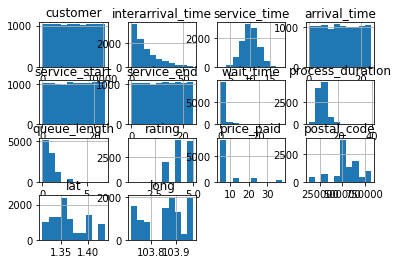

In [849]:
df.hist()

In [850]:
#important ones are wait_time, process_duration, queue_length, rating, price_paid (category was removed due to 100% collinearity with price_paid)

def calc_bias(row):
    total_bias = 0
    
    wait_time_bias = -row['wait_time'] * 0.006
    
    process_duration_bias = -0.15 + row['process_duration'] * 0.01 # <15mins will result in increasing dissatisfaction, >15mins will result in increasing satisfaction
    
    queue_length_bias = -0.25 if row['queue_length'] >= 5 else -0.16 if row['queue_length'] >= 4 else -0.04 if row['queue_length'] >= 2 else 0.1
    
    rating_bias = -0.7 if row['rating'] == 1 else -0.5 if row['rating'] == 2 else -0.2 if row['rating'] == 3 else 0.3 if row['rating'] == 4 else 0.8
    
    price_paid_bias = row['price_paid'] * rating_bias * 0.01 # high price_paid could be a satisfier or dissatisfier based on rating
    
    total_bias = wait_time_bias + process_duration_bias + queue_length_bias + rating_bias + price_paid_bias
    
    return total_bias

In [851]:
df['bias'] = df.apply(calc_bias, axis = 1)
df.head()

,customer,interarrival_time,service_time,arrival_time,service_start,service_end,wait_time,process_duration,queue_length,rating,price_paid,category,postal_code,lat,long,bias
0,1,4.78,10.30,10.07,10.07,10.25,0.00,10.30,1,3,4.8,H,508913,1.37093,103.97119,-0.15660
1,2,3.83,7.22,10.13,10.25,10.37,6.47,13.68,2,5,4.8,H,540330,1.39681,103.88936,0.74638
2,3,9.78,6.77,10.30,10.37,10.48,3.92,10.67,2,3,22.8,PWBH,670260,1.38840,103.78793,-0.35242
3,4,0.38,10.42,11.30,11.30,11.48,0.00,10.42,1,4,22.8,PWBH,460211,1.32560,103.93241,0.42260
4,5,0.58,13.18,11.32,11.48,11.70,9.83,23.03,2,1,4.8,H,470631,1.33331,103.91448,-0.75228


In [852]:
labels = []

for idx, row in df.iterrows():
    
    if 0.5 + row['bias'] > 1: #confirmation of certainty when probability > 1
        a = 1
        
    elif 0.5 + row['bias'] < 0: #prevention of negative probabilities
        a = 0
        
    else:
        a = 0.5 + row['bias']
        
    randomness = (0.4 * np.random.random_sample() - 0.2) #addition of randomness
    a += randomness
    
    #b = 1 - a
    #labels.append(np.random.choice([1, 0], p = [a, b])) if using probability, model will work exactly as well as the number of positive classes
    labels.append(1 if a > 0.5 else 0)
    

df['return'] = labels
df.drop('bias', axis = 1, inplace = True)

In [853]:
df.head()

,customer,interarrival_time,service_time,arrival_time,service_start,service_end,wait_time,process_duration,queue_length,rating,price_paid,category,postal_code,lat,long,return
0,1,4.78,10.30,10.07,10.07,10.25,0.00,10.30,1,3,4.8,H,508913,1.37093,103.97119,0
1,2,3.83,7.22,10.13,10.25,10.37,6.47,13.68,2,5,4.8,H,540330,1.39681,103.88936,1
2,3,9.78,6.77,10.30,10.37,10.48,3.92,10.67,2,3,22.8,PWBH,670260,1.38840,103.78793,0
3,4,0.38,10.42,11.30,11.30,11.48,0.00,10.42,1,4,22.8,PWBH,460211,1.32560,103.93241,1
4,5,0.58,13.18,11.32,11.48,11.70,9.83,23.03,2,1,4.8,H,470631,1.33331,103.91448,0


In [854]:
df['return'].value_counts()

1    8406
0    1872
Name: return, dtype: int64

In [855]:
X = pd.DataFrame(df, columns = ['wait_time', 'process_duration', 'queue_length', 'rating', 'price_paid', ])
y = df['return']

In [856]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE

In [857]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2022)

In [858]:
logreg = LogisticRegression(random_state = 2022)
logreg.fit(X_train, y_train.values.ravel())
print("logreg Coefficients:",logreg.coef_)

y_pred = logreg.predict(X_test)
print('\n-------------accuracy-------------')
print('Testing accuracy %s' % accuracy_score(y_test, y_pred)) #accuracy can be adjusted accordingly

print('\n-------------confusion matrix-------------')
print(confusion_matrix(y_test, y_pred))
print('\n-------------classification report-------------')
print(classification_report(y_test, y_pred))
# poor recall score for negative class. it is okay since business-wise, it is more costly to have FP than FN

### create Pickle!

pickle_out = open("logreg.sav", "wb")
pickle.dump(logreg, pickle_out)
pickle_out.close()

logreg Coefficients: [[-0.59160738  0.30307405 -0.22639773  9.15397085 -0.04689639]]

-------------accuracy-------------
Testing accuracy 0.9839494163424124

-------------confusion matrix-------------
[[ 378    0]
 [  33 1645]]

-------------classification report-------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       378
           1       1.00      0.98      0.99      1678

    accuracy                           0.98      2056
   macro avg       0.96      0.99      0.97      2056
weighted avg       0.99      0.98      0.98      2056



In [859]:
rfe = RFE(logreg, n_features_to_select=4)
fit = rfe.fit(X, y.values.ravel())
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

selected = fit.support_

#get the top-4 feature_names to see if simulation did work as intended
feature_names = X.columns
print(feature_names.to_numpy()[selected])

Num Features: 4
Selected Features: [ True  True  True  True False]
Feature Ranking: [1 1 1 1 2]
['wait_time' 'process_duration' 'queue_length' 'rating']


In [860]:
#checking to see if pickle works
pickle_in = open('logreg.sav', 'rb')
model = pickle.load(pickle_in)

model.predict(X_test)

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)